# MLP Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline

import logging

logging.basicConfig(level=10)
logger = logging.getLogger()

import shutil
from os import remove
import cPickle as pkl
from os.path import expanduser, exists

This time we are not going to generate the data but rather use real world annotated training examples.

In [258]:
# Dataset creation

import numpy as np
import math
import random
import csv
from neon.data import DataIterator

root_path = expanduser('~/data/ca-su-exercises')
#root_path = expanduser('~/data/ca-su-activity')
class WorkoutDS(object):

    # Number of examples
    num_train_examples = None
    num_test_examples = None

    # Number of classes
    num_labels = None
    num_features = None
    
    # Indicator if the data has been loaded yet
    initialized = False
    
    # Mapping of integer class labels to strings
    human_labels = {}
    
    def human_label_for(self, id):
        return self.human_labels[id]
    
    # Loads a label mapping from file. The file should contain a CSV tabel mapping integer labels to human readable
    # labels. Integer class labels should start with 1
    def load_label_mapping(self, filename):
        with open(expanduser(filename), 'rb') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            csvfile.seek(0)
            csv_data = csv.reader(csvfile, dialect)
            next(csv_data, None)  # skip the headers
            label_mapping = {}
            for row in csv_data:
                # We need to offset the labels by one since counting starts at 0 in python...
                label_mapping[int(row[0]) - 1] = row[1]
        return label_mapping
                
    # Load examples from given CSV file. The dataset should already be splitted into test and train externally
    def load_examples(self, filename):
        with open(expanduser(filename), 'rb') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            csvfile.seek(0)
            csv_data = csv.reader(csvfile, dialect)
            next(csv_data, None)  # skip the headers
            y = []
            X = []
            for row in csv_data:
                label = int(row[0]) - 1
                y.append(label)
                X.append(map(lambda x: float(x)*2-1, row[1:]))
                
            X = np.reshape(np.asarray(X, dtype = float), (len(X), len(X[0])))  
            y = np.reshape(np.asarray(y, dtype = float), (X.shape[0], 1))
            
            return X,y
    
    # Load label mapping and train / test data from disk.
    def __init__(self):
        logger.info("Loading DS from files...")
        self.human_labels = self.load_label_mapping(root_path+'/labeled_exercise_data_f400_LABELS.csv')
        self.num_labels = len(self.human_labels)
        
        X_train, y_train = self.load_examples(root_path+'/labeled_exercise_data_f400_TRAIN.csv')
        X_test, y_test = self.load_examples(root_path+'/labeled_exercise_data_f400_TEST.csv')
        
        self.num_features = X_train.shape[1]
        self.num_train_examples = X_train.shape[0]
        self.num_test_examples = X_test.shape[0]
        self.feature_count = X_train.shape[1]
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    # Get the dataset ready for Neon training
    def train(self):
        return DataIterator(
            X=self.X_train, 
            y=self.y_train, 
            nclass=self.num_labels, 
            make_onehot=True,
            lshape=(self.num_features,1,1))
    
    def test(self):
        # Assign training and test datasets
        return DataIterator(
            X=self.X_test, 
            y=self.y_test,
            nclass=self.num_labels, 
            make_onehot=True,
            lshape=(self.num_features,1,1))
        
dataset = WorkoutDS()
print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.feature_count
print "Number of labels:", dataset.num_labels

Number of training examples: 4853
Number of test examples: 959
Number of features: 1200
Number of labels: 3


At first we want to inspect the class distribution of the training and test examples.

In [259]:
from ipy_table import *
from operator import itemgetter

def calculate_dist(labels):
    dist = np.zeros((1, dataset.num_labels))
    for i in range(0, labels.shape[0]):
        dist[0, labels[i, 0]] += 1
    return np.transpose(dist)

train_dist = calculate_dist(dataset.y_train)
test_dist = calculate_dist(dataset.y_test)

train_ratio = train_dist / dataset.num_train_examples
test_ratio = test_dist / dataset.num_test_examples

# Fiddle around to get it into table shape
table = np.hstack((np.zeros((dataset.num_labels,1), dtype=int), train_dist, train_ratio, test_dist, test_ratio))
table = np.vstack((np.zeros((1, 5), dtype=int), table)).tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[i + 1][0] = s
    
table.sort(lambda x,y: cmp(x[1], y[1]))

table[0][0] = ""
table[0][1] = "Train"
table[0][2] = "Train %"
table[0][3] = "Test"
table[0][4] = "Test %"

make_table(table)
set_global_style(float_format='%0.0f', align="center")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(0, align="left")

,Train,Train %,Test,Test %
biceps-curl,1160,0.24%,583,0.61%
triceps-extension,1611,0.33%,114,0.12%
lateral-raise,2082,0.43%,262,0.27%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [4605 2191 3627]


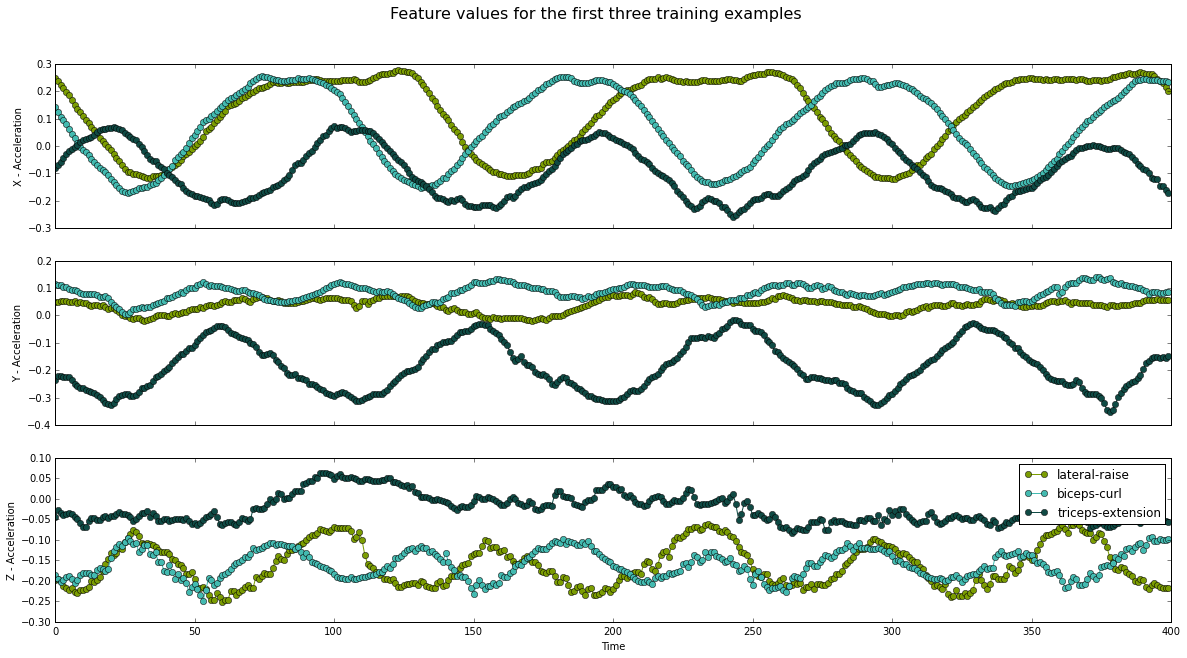

In [261]:
from matplotlib import pyplot, cm
from pylab import *

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

# Retrieve a human readable label given the idx of an example
def label_of_example(i):
    return dataset.human_label_for(dataset.y_train[i, 0])

figure(figsize=(20,10))
ax1 = subplot(311)
setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('X - Acceleration')

ax2 = subplot(312, sharex=ax1)
setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel('Y - Acceleration')

ax3 = subplot(313, sharex=ax1)
ax3.set_ylabel('Z - Acceleration')

for i in plot_ids:
    c = np.random.random((3,))

    ax1.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,0:400], '-o', c=c)
    ax2.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,400:800], '-o', c=c)
    ax3.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,800:1200], '-o', c=c)
    
legend(map(label_of_example, plot_ids))
suptitle('Feature values for the first three training examples', fontsize=16)
xlabel('Time')
show()

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [262]:
from neon.backends import gen_backend
from neon.layers import Affine, Dropout, GeneralizedCost
from neon.transforms import Rectlin, Logistic
from neon.transforms.cost import CrossEntropyMulti 
from neon.initializers import Uniform, Constant 
import time
from neon.optimizers import GradientDescentMomentum
from neon.models import Model
from neon.callbacks.callbacks import Callbacks
from neon.transforms import  Misclassification

# General settings
max_epochs = 10
batch_size = 30 # max(10, min(100, dataset.num_train_examples/10))
random_seed = 42 # Take your lucky number


# Storage director of the model and its snapshots
file_path = '%s/workout-mlp.pkl' % root_path
if exists(file_path):
    remove(file_path)

# Captured errors for the different epochs
train_err = []
test_err = []

print 'Epochs: %d Batch-Size: %d' % (max_epochs, batch_size)

# Generate layers and a MLP model using the given settings
def model_gen():
    init_norm = Uniform(low=-0.1,high=0.1)
    bias_init = Constant(val = 1.0)    

    layers = []
    layers.append(Affine(
            nout=250, 
            init=init_norm, 
            bias=bias_init,
            activation=Rectlin()))
    
    layers.append(Dropout(
            name="do_2", 
            keep = 0.9))

    layers.append(Affine(
            nout=100, 
            init=init_norm, 
            bias=bias_init,
            activation=Rectlin()))
    
    layers.append(Dropout(
            name="do_3", 
            keep = 0.9))
    
    layers.append(Affine(
            nout = dataset.num_labels, 
            init=init_norm, 
            bias=bias_init,
            activation=Logistic()))
    
    model = Model(layers=layers)
    return model

# Set logging output...
for name in ["neon.util.persist"]:#, "neon.datasets.dataset", "neon.models.mlp"]:
    dslogger = logging.getLogger(name)
    dslogger.setLevel(40)

print "Starting training..."
start = time.time()
lrate = 0.01

# Uncomment line below to run on CPU backend
backend = gen_backend(backend='cpu',
             batch_size=batch_size,
             rng_seed=random_seed,
             stochastic_round=False)
    
cost = GeneralizedCost(
        name = 'cost', 
        costfunc = CrossEntropyMulti())

optimizer = GradientDescentMomentum(
    learning_rate = lrate, 
    momentum_coef=0.9)

# set up the model and experiment
model = model_gen()

callbacks = Callbacks(model, dataset.train(), output_file=root_path+'/workout-mlp.h5',
                  progress_bar=True, valid_set=dataset.test(), valid_freq=1)

# add a callback that saves the best model state
callbacks.add_save_best_state_callback(file_path)
callbacks.add_serialize_callback(serialize_schedule =1, save_path=root_path+'/workout-mlp-ep', history=100) 

# Uncomment line below to run on GPU using cudanet backend
# backend = gen_backend(rng_seed=0, gpu='cudanet')
experiment = model.fit(
    dataset.train(), 
    optimizer=optimizer, 
    num_epochs=max_epochs, 
    cost=cost,
    callbacks=callbacks)

print('Misclassification error = %.1f%%'
      % (model.eval(dataset.test(), metric=Misclassification())*100))

# Run the training, and dump weights
# dest_path = root_path+'/workout-ep' + str(num_epochs) + '.prm'
# if num_epochs > 0:
#     res = experiment.run()
#     train_err.append(res['train']['MisclassPercentage_TOP_1'])
#     test_err.append(res['test']['MisclassPercentage_TOP_1'])
    # Save the weights at this epoch
#     shutil.copy2(file_path, dest_path)
#     print "Finished epoch " + str(num_epochs)
# else:
#     model.epochs_complete = 0
#     serialize(model.get_params(), dest_path)

print "Finished training!"
end = time.time()
print "Duration", end - start, "seconds"


Epochs: 10 Batch-Size: 30
Starting training...
Epoch 0   [Train |████████████████████|  162/162  batches, 0.61 cost, 0.78s][Validation 0.61 cost, 0.05s]
Epoch 1   [Train |████████████████████|  162/162  batches, 0.32 cost, 0.79s][Validation 0.56 cost, 0.04s]
Epoch 2   [Train |████████████████████|  162/162  batches, 0.31 cost, 0.81s][Validation 0.55 cost, 0.05s]
Epoch 3   [Train |████████████████████|  162/162  batches, 0.30 cost, 0.79s][Validation 0.48 cost, 0.05s]
Epoch 4   [Train |█████████████████   |  143/162  batches, 0.29 cost, 0.72s][Validation 0.46 cost, 0.04s]
Epoch 5   [Train |████████████████████|  162/162  batches, 0.29 cost, 0.77s][Validation 0.44 cost, 0.05s]
Epoch 6   [Train |████████████████████|  162/162  batches, 0.28 cost, 0.79s][Validation 0.41 cost, 0.05s]
Epoch 7   [Train |████████████████████|  162/162  batches, 0.27 cost, 0.79s][Validation 0.39 cost, 0.05s]
Epoch 8   [Train |█████████████████   |  144/162  batches, 0.26 cost, 0.71s][Validation 0.34 cost, 0.04s]

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

6


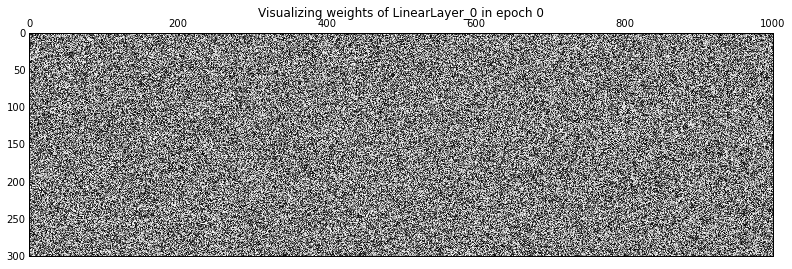

In [263]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
from IPython.html import widgets
from IPython.html.widgets import interact

layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers)))

def closestSqrt(i):
    N = int(math.sqrt(i))
    while True:
        M = int(i / N)
        if N * M == i:
            return N, M
        N -= 1
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = root_path+'/workout-mlp-ep_' + str(n)
    params = pkl.load(open(dest_path, 'r'))

    print len(params['layer_params_states'])
    
    wts = params['layer_params_states'][layer_names.index(layer_name)]['params']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=widgets.IntSliderWidget(description='epochs',
                                        min=0, max=max_epochs-1, value=0, step=1))


Store the layer weights in a packed raw file. The layers need to be put into the file in the same order as they appear in the network.

In [40]:
import numpy as np
import struct

def layer_names(params):
    layer_names = params.keys()
    layer_names.remove('epochs_complete')
    # Sort layers by their appearance in the model architecture
    # Since neon appands the index to the layer name we will use it to sort
    layer_names.sort(key=lambda x: int(x.split("_")[-1]))
    return layer_names

def getweights(file_name):
    vec = []
    # Load a stored model file from disk (should have extension prm)
    params = pkl.load(open(file_name, 'r'))
    layers = layer_names(params)

    for layer in layers:
        # Make sure our model has biases activated, otherwise add zeros here
        b = params[layer]['biases']
        w = params[layer]['weights']

        newvec = np.ravel(np.hstack((b,w)))
        [vec.append(nv) for nv in newvec]
    return vec

weights = getweights(root_path+'/workout-mlp.prm')
f = open(root_path+"/weights.raw","wb")

#  You can use 'd' for double and < or > to force endinness
bin_data=struct.pack('d'*len(weights), *weights)

f.write(bin_data)
f.close()


Store the labels in a file so we are able to decode the labels the MLP produces into human readable strings. They need to be in index ascending order.

In [41]:
import collections

labels = collections.OrderedDict(sorted(dataset.human_labels.items())).values()

f = open(root_path+"/labels.txt","wb")

for label in labels:
  f.write("%s\n" % label)
f.close()

Let's visualize the error to see if the network has trained properly or if we are overfitting.

Test error = 0.0%
Train error = 9.9%
Minibatches per epoch: 161.80


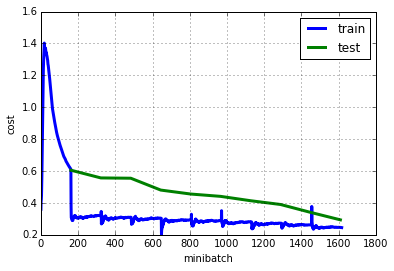

In [264]:
import h5py
logged = h5py.File(root_path+'/workout-mlp.h5', "r")
epochs = logged['config'].attrs['total_epochs']
minibatches = logged['config'].attrs['total_minibatches']

print('Test error = %.1f%%'
      % (model.eval(dataset.test(), metric=Misclassification())*100))

print('Train error = %.1f%%'
      % (model.eval(dataset.train(), metric=Misclassification())*100))

print "Minibatches per epoch: %0.2f" % (minibatches * 1.0/epochs)

pyplot.plot(range(0, minibatches), logged['cost/train'], linewidth=3, label='train')
pyplot.plot(range(minibatches / epochs, minibatches, minibatches / epochs), logged['cost/validation'], linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("minibatch")
pyplot.ylabel("cost")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [265]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

def predict(model, dataset):
    running_error = 0.0
    nprocessed = 0
    dataset.reset()
    predictions = np.empty((3, 0), dtype="float32")
    nprocessed = 0
    for x, t in dataset:
        pred = model.fprop(x, inference=True).asnumpyarray()
        bsz = min(dataset.ndata - nprocessed, model.be.bsz)
        nprocessed += bsz
        predictions = np.hstack((predictions, pred[:,:bsz]))
    return predictions

# confusion_matrix(y_true, y_pred)
predicted = predict(model, dataset.test())

y_true = dataset.y_test
y_pred = np.argmax(predicted, axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt

actual \ predicted,biceps-curl,lateral-raise,triceps-extension
biceps-curl,583,0,0
lateral-raise,0,262,0
triceps-extension,0,0,114
